# ICS H198 Report: Investigation of Interpolation methods on SDO images

Interpolation in image processing is a technique used to upscale the pixel resolution of an image. When images are visually displayed, they are made up of a discrete number of pixels, each with a defined value. To upscale an image means to increase the number of pixels that make up an original image, but since larger images require more pixels, there must be a method used to increase the pixel count of an image, while retaining the general picture. This is where interpolation comes into play, by approximating the values of missing pixels based on the position of pixels that are defined. This report will investigate three methods of conducting interpolation which are bilinear, spline, and sync.

# Setup

Below is the code to import the necessary Python libraries and HITS-SDO augmentation code

In [2]:
# Import libraries

import os
import numpy as np
from scipy import interpolate
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
import glob
from augmentation_list import AugmentationList
from augmentation import Augmentations
import streamlit as st
from PIL import Image
from augmentation_test import read_image
from io import BytesIO
import tempfile
import json
from streamlit_cropper import st_cropper
from streamlit_modal import Modal

# Import HITS-SDO augmentaion
import augmentation

First we will want to get an image and load it up. The image that we will be using is 4096x4096, and we will be considering it both in RGB and Grayscale format

<function matplotlib.pyplot.show(close=None, block=None)>

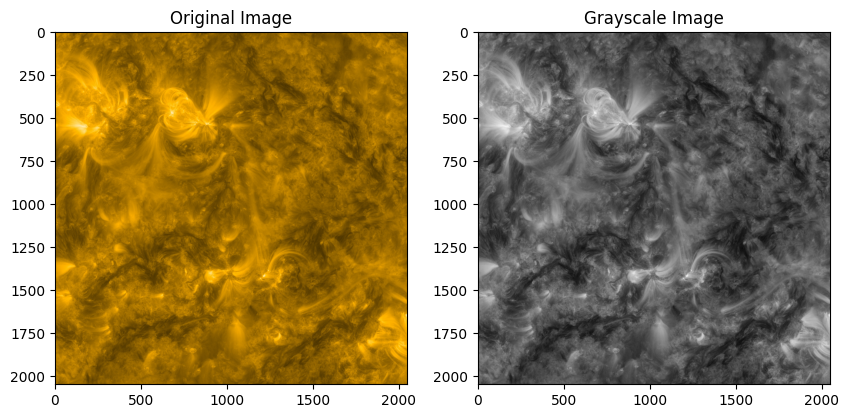

In [3]:
# Get image
img_loc = 'data/euv/fd/2048x2048 Solar Image.png'
img = cv.imread(img_loc)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Show images
fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].set_title('Original Image')
axs[0].imshow(img_rgb)
axs[1].set_title('Grayscale Image')
axs[1].imshow(img_gray, cmap='gray')
plt.show

# Downscaling the Image

In order to test the effectiveness of our interpolation methods, we will downscale our images into smaller resolution sizes (2048x2048, 1024x1024, 512x512, 256x256, 128x128). This will be done by taking the average of the nieghboring pixels to make a single average pixel, thus reducing the size of the image.

<function matplotlib.pyplot.show(close=None, block=None)>

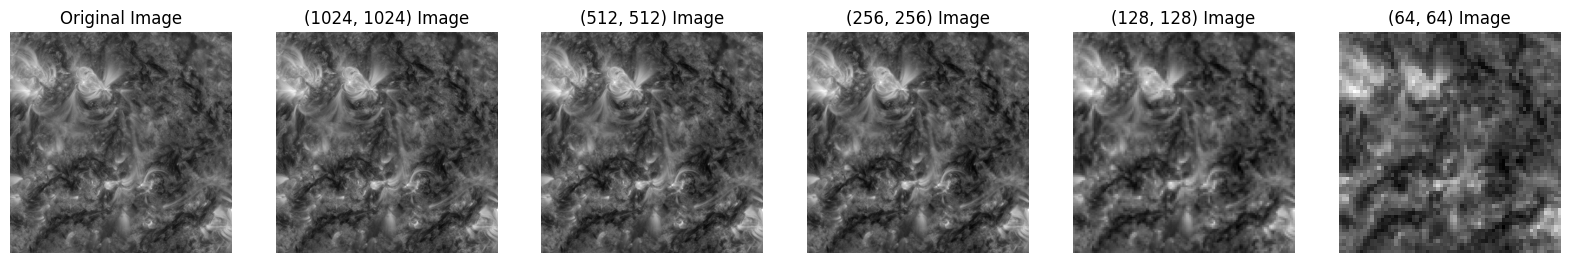

In [4]:
# Create reduced image scales
arr_gray = [img_gray]

fig, axs = plt.subplots(1, 6, figsize=(20,15))
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[0].imshow(img_gray, cmap='gray')

# Loop through 5 reduced sizes
for c in range(5):
    img = arr_gray[-1]
    x = int(img.shape[0] // 2)
    y = int(img.shape[1] // 2)
    arr_gray.append(cv.resize(img, (x,y), cv.INTER_AREA))
    axs[c+1].set_title(str(arr_gray[-1].shape) + ' Image')
    axs[c+1].axis('off')
    axs[c+1].imshow(arr_gray[-1], cmap='gray')
plt.show


# Bilinear Interpolation

Next, we will now want to incorporate our interpolation methods onto these images. We will first begin with bilinear interpolation and the code for it is a such.

<function matplotlib.pyplot.show(close=None, block=None)>

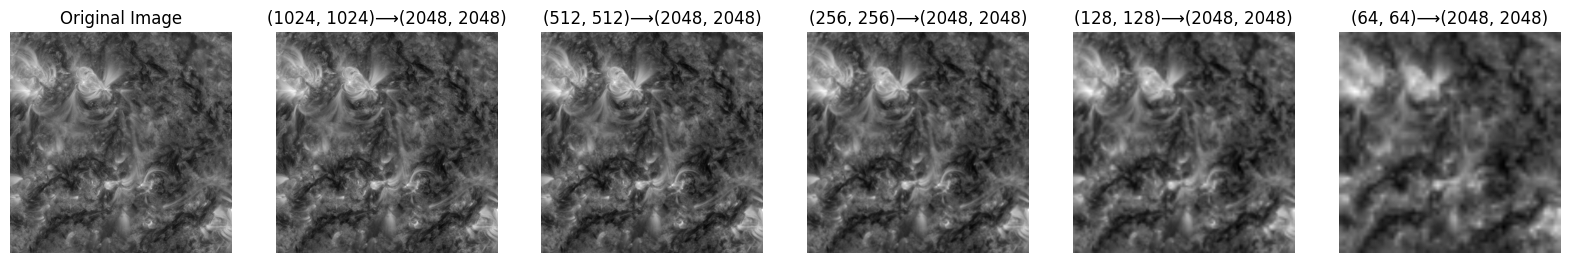

In [5]:
# Perform bilinear interpolation

bilin_gray = [img_gray]

fig, axs = plt.subplots(1, 6, figsize=(20,10))
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[0].imshow(img_gray, cmap='gray')

for c in range(5):
    bilin_gray.append(cv.resize(arr_gray[c+1], img_gray.shape, cv.INTER_LINEAR))
    axs[c+1].set_title(str(arr_gray[c+1].shape) + '\u27F6' + str(bilin_gray[c].shape))
    axs[c+1].axis('off')
    axs[c+1].imshow(bilin_gray[-1], cmap='gray')

plt.show  
    


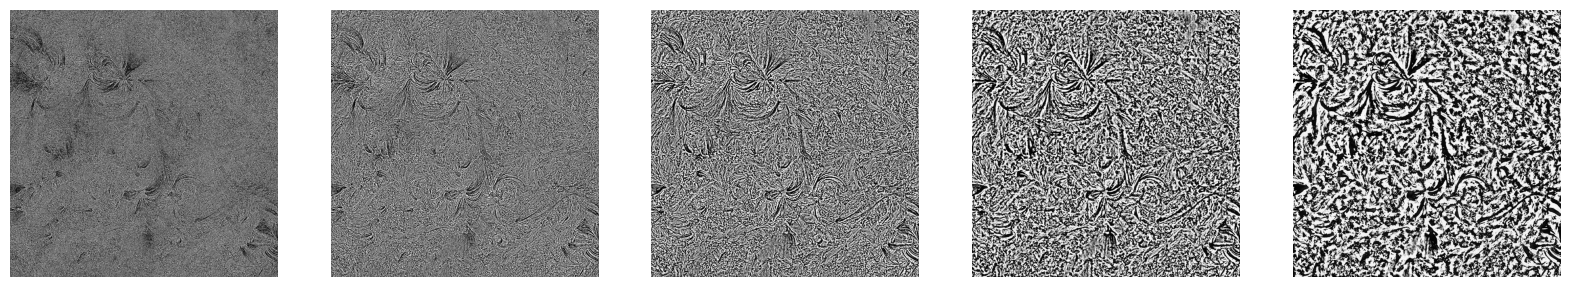

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(20,10))

for c in range(5):
    axs[c].imshow(img_gray-bilin_gray[c+1], cmap='gray')
    axs[c].axis('off')



    

<function matplotlib.pyplot.show(close=None, block=None)>

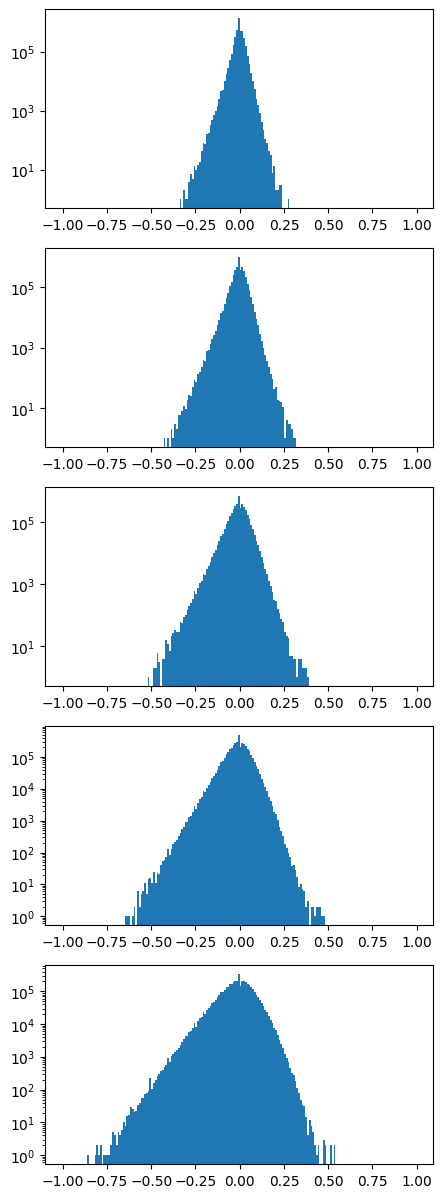

In [46]:
# Create histogram of discrepency 
bilin_dis = []
legend = []
fig, axs = plt.subplots(5, 1, figsize=(5,15))


for c in range(5):
    dis = ((img_gray.astype(np.float32) - bilin_gray[c+1].astype(np.float32)) / img_gray.astype(np.float32)).astype(np.float32)
    bilin_dis.append(dis.flatten())
    legend.append(arr_gray[c+1].shape)
    axs[c].set_yscale('log')
    axs[c].hist(bilin_dis[c], np.arange(-1,1,.01))

plt.show

In [8]:
print(np.min(img_gray) - np.min(bilin_gray[1]))

249


C:\Users\starf\AppData\Local\Temp\ipykernel_3100\1730916277.py:1: RuntimeWarning: overflow encountered in scalar subtract
  print(np.min(img_gray) - np.min(bilin_gray[1]))


# Spline Interpolation

This is spline interpolation

<function matplotlib.pyplot.show(close=None, block=None)>

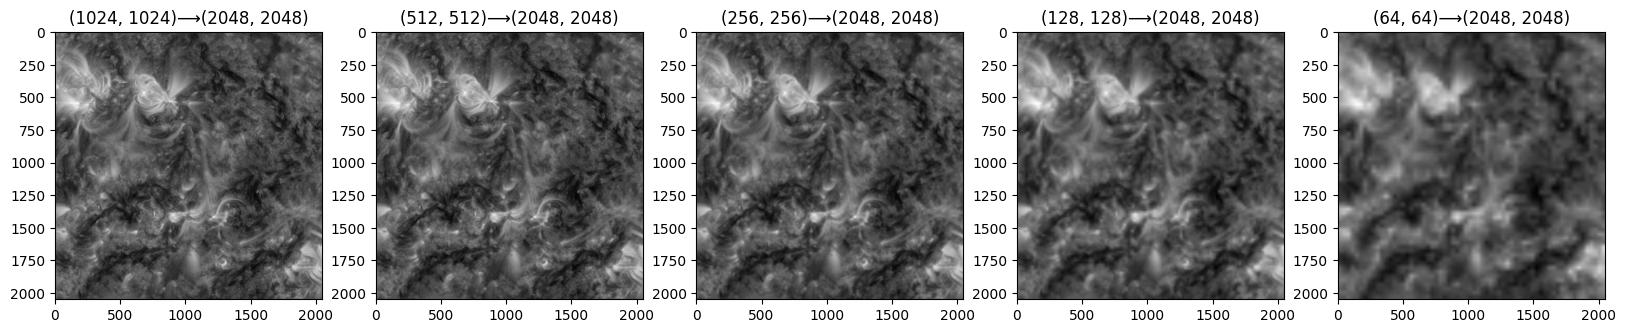

In [9]:
# Perform bilinear interpolation

spline_gray = []


fig, axs = plt.subplots(1, 5, figsize=(20,10))

for c in range(5):
    spline_gray.append(cv.resize(arr_gray[c+1], img_gray.shape, cv.INTER_CUBIC))
    axs[c].set_title(str(arr_gray[c+1].shape) + '\u27F6' + str(bilin_gray[c].shape))
    axs[c].imshow(spline_gray[-1], cmap='gray')


plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

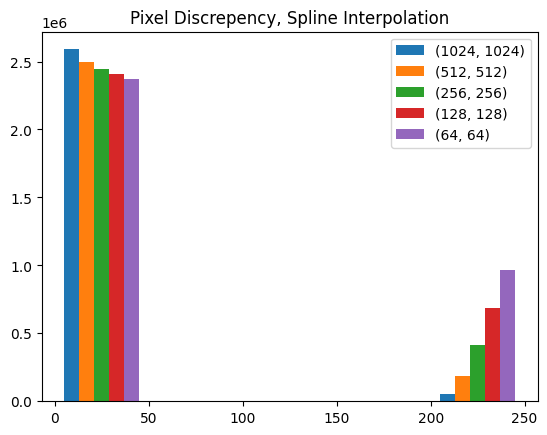

In [10]:
# Create histogram of discrepency 
spline_dis = []
legend = []
#fig, axs = plt.subplots(5, 1, figsize=(5,15))
for c in range(5):
    dis = abs(spline_gray[c] - img_gray)
    spline_dis.append(dis.flatten())
    legend.append(arr_gray[c+1].shape)

plt.title('Pixel Discrepency, Spline Interpolation')

plt.hist(spline_dis, bins=np.arange(0,300,50))
plt.legend((legend))
plt.show